In [1]:
# Importing Required Packages
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import copy
import random
from statistics import mean
from numpy import linalg as LA
import warnings
from collections import Counter
from matplotlib.ticker import PercentFormatter
import time

The state space is denoted by the set of tuples $\{[i,j]\}$ with $i,j\in\{0,1,2,3,4,5,6\}$. The state $[i,j]$ is located at the coordinates $i$ and $j$ with the origin at the bottom left corner. The actions are denoted by $N,S,W,E$ and we will map this through an function act into the corresponding change in state they induce. That is we define a function 'act' as 
$$act(N)=[0,1]$$
and so on. We also define a probability transition function in a natural fashion. Note that the goal is to reach red state and so we make the red state absorbing. 

Finally, we come to defining the reward function. We want to go from the blue state to the red state in minimum time. So any time spent outside these states should cost us. Effectively, we want the reward at any state to be $-1$ for every action and the cost to be $0$ at the final state. Since this state is absorbing our longer term goal of ensuring maximum reward ensures we spend minimum time outside the red state i.e. we reach the goal in minimum time.  

In [24]:
# Creating the state space.
N=7
states=[]
for i in range(N):
    for j in range(N):
        states.append(np.array([i,j]))

states_list = [state.tolist() for state in states]

# In our problem the observation set is the same as the set of states. So we get,
observations=states

# Demarking the red and blue states.
red=np.array([2,1])
blue=np.array([1,5])

# Creating a function to check if the state is at an edge.
def atEdge(s):
    return any(s==6) or any(s==0)

# Creating a function to check if the state is at a corner.
def atCorner(s):
    return list(s) in [[0,0],[0,6],[6,0],[6,6]]

# Checking atEdge and atCorner functions. 
# s=np.array([5,5])
# print(atEdge(s))
# print(atCorner(s))

# Creating action space.
actions = ['N','S','E','W']

# Function that maps actions into the change in coordinates they induce.
def act(action):
    if action=='N':
        return np.array([0,1])
    if action=='S':
        return np.array([0,-1])
    if action=='E':
        return np.array([1,0])
    if action=='W':
        return np.array([-1,0])
    
# Testing action function.
# np.array([2,3])+act('W')

# We define a function to count the number of reachable neighbours. 
def count_neigh_reach(s):
    count=0
    neighbours=[]
    for a in actions:
        pot_neigh=s+act(a)
        if not (list(pot_neigh) in states_list):
            continue
        count+=1
        neighbours.append(list(pot_neigh))
    return count, neighbours

# Describing the probability transition function.
def P(s,a,s_next):
    # We will make the red state absorbing.
    if all(s==red):
        if all(s_next==red):
            return 1.0
        else:
            return 0.0
    
    # This next case should never happen but to make it easier to debug if it does.
    if not (list(s_next) in states_list):
        warnings.warn("I will fall off the grid. Halp! (Next state is not on the grid)")
        return 0.0
    if not (list(s+act(a)) in states_list):
        warnings.warn("I will fall off the grid. Halp! (Action sends me off the grid)")
        return 0.0

    # If the next state is not at a metropolis distance of one we can never go there. 
    if LA.norm(s_next-s,1)!=1.0:  # ||[x,y]-[w,z]||_1 = |x-w|+|y-z|
        return 0.0 
    elif all(s_next-s==act(a)): # we go in the direcetion action takes us.
        return 0.75
    else:
        if atCorner(s):    # We go towards any of the other possible directions.
            return 0.25
        elif atEdge(s):    # We go towards any of the other possible directions.
            return 0.25/2
        else:
            return 0.25/3
        
# Testing the PTF.
# P(np.array([0,6]),'E',np.array([1,6]))

# We now define our reward function as an array. 
true_R=-1*np.ones([N,N])
true_R[red[0],red[1]]=0

R=copy.deepcopy(true_R)
# Discount factor 
gamma =0.9

# We will now create a function that given the state generate the list of allowed action. 
# This is to avoid taking actions to fall out of the grid.
def allowed_actions(s):
    allow_act=[]
    for a in actions:
        if (list(s+act(a)) in states_list):
            allow_act.append(a)
    return allow_act

# Testing allowed actions.
# allowed_actions(red)

We will run value iteration to compute the value function and the optimal policy over our MDP. 

In [3]:
## Value iteration to obtain the optimal policy for the observable MDP.
eps=1e-4     # Threshold for value iteration convergence.

# We define the function that performs value iteration using a particular reward function 
# and outputs the opt policy.
def opt_pol(R):
    global eps     # Threshold for value iteration convergence.
    global gamma
    # Randomly initialize the value function and policy vector for value iteration.
    opt_pi=np.empty([7,7],dtype='object')
    V=-np.ones([7,7]) 
    V[red[0],red[1]]=0

    # We want to run the value iteration until the value function converges pointwise within eps.
    for k in range(200):
        prev_V=copy.deepcopy(V)
        for i in range(7):
            for j in range(7):
                # Our current state.
                s=np.array([i,j])
                max_V=-1e6
                # Now we iterate over all allowed actions and find the action which gives max value to bellman operator.
                for a in allowed_actions(s):
                    # Computing the expected value obtained from taking our action.
                    sum_value=0
                    for next_state in states:
                        sum_value+=P(s,a,next_state)*prev_V[next_state[0],next_state[1]]
                
                    # Compute value of bellman operator.
                    bel_V=R[s[0],s[1]]+gamma*sum_value
        
                    # If this value is more than what we have obtained so far update this action and value as the optimal.
                    if bel_V>max_V:
                        max_V=bel_V
                        opt_a=a
    
                # Having computed the optimal action and value for this round of value iteration we will update 
                # the value for each state.
                V[s[0],s[1]]=max_V
                opt_pi[s[0],s[1]]=opt_a
        
        max_delta_V=0
        for i in range(7):
            for j in range(7):
                if abs(V[i,j]-prev_V[i,j])>max_delta_V:
                    max_delta_V=abs(V[i,j]-prev_V[i,j])
                
        if max_delta_V<eps:
#             print('Value iteration converged after', i, 'iterations.')
#             print('Optimal policy is',opt_pi)
#             print('Optimal Value functions are',V)
            break
    print(V[blue[0],blue[1]])
    return opt_pi

opt_pi=opt_pol(true_R)

-5.414140054611322


In [4]:
opt_pi

array([['E', 'E', 'E', 'S', 'S', 'S', 'S'],
       ['E', 'E', 'S', 'S', 'S', 'S', 'S'],
       ['N', 'N', 'S', 'S', 'S', 'S', 'S'],
       ['W', 'W', 'S', 'S', 'S', 'S', 'S'],
       ['W', 'W', 'W', 'S', 'S', 'S', 'S'],
       ['W', 'W', 'W', 'W', 'S', 'S', 'W'],
       ['W', 'W', 'W', 'S', 'S', 'S', 'S']], dtype=object)

In [5]:
# Next we will simulate the MDP. But to do so first we need to generate the next state and observation probabilistically.
# This function takes the current state and actions and generates the next state probabilisitically.
def next_s(s,a):
    U=random.uniform(0, 1) # U is a uniformly distributed over [0,1]
    # We first compute the set of (and number of) states we can reach from our current states
    no_states,pot_states=count_neigh_reach(s)
#     print(pot_states)
    # We compute lower bound for the probability bracket computed so far.
    P_so_far=0
    for s_next in pot_states:
        # count_neigh_reach outputs a list of lists so we convert it into an array.
        s_next=np.array(s_next)
        if P_so_far<=U and U<P_so_far+P(s,a,s_next):
            return s_next
        P_so_far+=P(s,a,s_next)
#         print(P_so_far)
    # In the event U=1.0 (which will happen with probability 0) we want the final neighbour to be sent.
    return s_next

In [6]:
# We let our MDP run iters times with time horizon T. 
iters=int(5e1)
T = int(2e1)

# Our next function takes a policy and a reward function and uses empirical runs to estimate 
# the V(blue) for this policy.
def estV(state,pol,R):
    # We use global time horizon and number of steps for evaluating policy.
    global T,iters

    # We let our MDP run N times with optimal to obtain the average reward over runs. 
    rewards1=[]
    
    for k in range(iters):
    #     print(k)
        # Initialize our state, belief and reward
        s=state
        reward=0.0
    
        for i in range(T):
            # We pick the optimal action to be taken depending on our belief. 
            opt_action=pol[s[0],s[1]]  # Take the optimal policy itself.
        
            # Update the reward obtained in this step.
            reward+=gamma**i*R[s[0],s[1]]
        
            # Update the next state probabilistically.
            s=next_s(s,opt_action)
    
            # We we reach the red state goal we will terminate.
            if all(s==red):
                break
        
        rewards1.append(reward)
    return mean(rewards1)
    
# We have obtained the rewards over N runs, we print the average for now.
print('Over',iters,'runs with time horizon length',T,'the average rewards for the given policy was',estV(blue,opt_pi,R))

Over 50 runs with time horizon length 20 the average rewards for the given policy was -5.095367846923561


NameError: name 'rewards1' is not defined

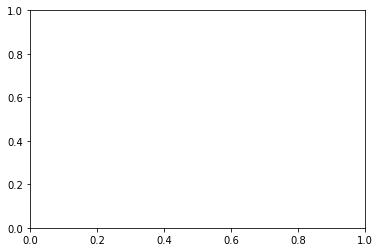

In [7]:
# # print('Over',N,'runs with time horizon length',T,'the average rewards with the first greedy policy was',mean(rewards))

# n_bins = 10

# fig, axs = plt.subplots(1, 1)

# # We can set the number of bins with the *bins* keyword argument.
# axs.hist(rewards1, bins=n_bins)

We have obtained the true optimal policy as well as a way to estimate the value of a policy for any reward function. We will now generate the basis function for the true reward function. We can evaluate the value for a policy at every basis function to know the value function for any reward obtained from a linear combination of rewards functions.

In [8]:
# Basis function. The basis has dimension 49 and each element takes 1 at a unique state and 0 everywhere else.  
phi=np.zeros([N,N,N*N])

for i in range(N):
    for j in range(N):
        phi[i,j,i*7+j]=1

alpha=np.ones(N*N)
# Next we generate a function that takes the weight vector and generates the reward matrix from the basis.
def rew(w):
#     global phi,N
#     for k in range(N*N):
#         R+=w[k]*phi[:,:,k]

    # Fast trick to avoid computation. Exploits nature of phi.
    global N
    R=np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            R[i,j]=w[i*7+j]
    
    return R

# Testing reward generation from phi.
# rew(alpha)

In [9]:
# Let us first obtained the value function at s0 for a particular policy for each basis function.
def basis_V_vec(s0,pol):
    global N,phi
    
    values=np.zeros(N*N)
    
    for k in range(N*N):
        values[k]=estV(s0,pol,phi[:,:,k])
        
    return values

# Testing the vector of a values
t_test=time.time()
print(basis_V_vec(blue,opt_pi))
print(time.time()-t_test)

[0.03357302 0.06861494 0.09797016 0.27700506 0.133488   0.1635498
 0.0162     0.03901189 0.52749886 0.61927793 0.76048698 1.0002749
 1.172044   0.10458    0.03689134 0.         0.1504886  0.27224923
 0.23435082 0.10116    0.0324     0.02064978 0.03186032 0.04275148
 0.04999482 0.01869782 0.         0.         0.         0.
 0.         0.         0.01062882 0.         0.         0.
 0.         0.         0.         0.         0.         0.0118098
 0.         0.         0.         0.         0.         0.
 0.        ]
5.096571445465088


In [234]:
# Generate an initial guess for policy using random actions at each state.
rand_pi=np.empty([7,7],dtype='object')
for i in range(N):
    for j in range(N):
        rand_pi[i,j]=random.choice(allowed_actions(np.array([i,j]))) # We want to be sure we don't go out of the grid.

# We also define the loss function. This is nothing but min of {x , 2x}. Implemented using cvxpy atoms.
def l(x):
    if x>=0:
        return x
    else:
        return 2*x      # Can play around with this 2 here.

# We will perform a deterministic number of steps until we come up with a good stopping criteria for obtaining 
# our reward function. 
basis_V_opt=basis_V_vec(blue,opt_pi) # This needs to be computed only once.
# set_pi=[pi]

# Set up the variable and constraints for optimizing.
alpha = cp.Variable(N*N)
constraints = [-1 <= alpha, alpha <= 0]

In [235]:
obj=0
pi=rand_pi

# M denotes the number of iterations we run the approach from section 5.
M=40
# Things to be captured for plotting.
dev_opt_pi =[sum(sum(pi!=opt_pi))] # Number of states where the optimal action for learned reward function differs from the true state.
true_v_of_pol=[estV(blue,pi,true_R)] # True value of obtained pol. (estimated using empirical runs.)
R_est=np.zeros([N,N,M])

for m in range(M):
    # We now obtain objective function by adding the expression for the current policy.
    basis_V_pi=basis_V_vec(blue,pi)
    obj-=cp.minimum((basis_V_opt-basis_V_pi)@alpha,2*((basis_V_opt-basis_V_pi)@alpha))  # Negative sign here to make our problem minimization.
    
    # We can now optimize.
    objective = cp.Minimize(obj)
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    
    # The optimal value for x is stored in `x.value`. We use it to compute the reward and the corresponding optimal policy..
    R = rew(alpha.value)
    print(m)
    pi = opt_pol(R)
    
    # Collecting rewards and policy infomration at each step for plotting purpose. 
    R_est[:,:,m]=copy.deepcopy(R)
    dev_opt_pi.append(sum(sum(pi!=opt_pi)))
    true_v_of_pol.append(estV(blue,pi,true_R))
    
    

0
-1.7127488816547807
1
-2.330518986684774
2
-3.054482649559659
3
-5.151638055459831
4
-5.233277499405137
5
-7.185484866296059
6
-5.627724428763574
7
-7.1978262813539144
8
-5.832284819686315
9
-7.216875141437499
10
-7.223987050241774
11
-7.216917055013763
12
-7.669708612482323
13
-7.224194084843285
14
-7.22419396544935
15
-7.224193919304573
16
-7.224193867740469
17
-7.026886865334661
18
-4.755028533205609
19
-7.216917128406349
20
-7.038651096349167
21
-7.112149389940258
22
-7.083757534927725
23
-7.112149343460913
24
-7.090193325142662
25
-5.981497568395235
26
-6.979013085259643
27
-5.506421531371312
28
-7.601296177129637
29
-7.605337718214137
30
-7.547413444668731
31
-7.5474134064208
32
-7.5479613495412
33
-7.194572399030866
34
-7.579766167525237
35
-6.856082809898061
36
-5.123313830808149
37
-7.121371201241874
38
-7.60161552874613
39
-7.572941338144696


Text(0, 0.5, '$\\# (\\pi(s)\\neq\\pi^*(s)})$')

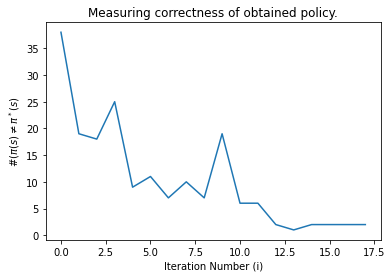

In [270]:
plt.plot(dev_opt_pi[:18])
plt.title('Measuring correctness of obtained policy.')
plt.xlabel('Iteration Number (i)')
plt.ylabel(r'$\# (\pi(s)\neq\pi^*(s)})$')

Text(0, 0.5, '$V^\\pi(\\bar{s})$')

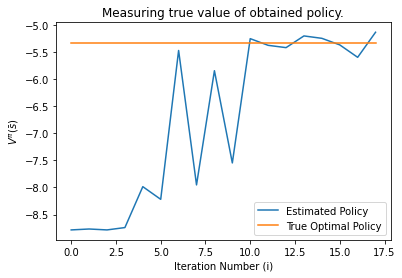

In [274]:
plt.plot(true_v_of_pol[:18],label='Estimated Policy')
plt.plot(estV(blue,opt_pi,true_R)*np.ones_like(true_v_of_pol)[:18],label='True Optimal Policy')
plt.legend()
plt.title('Measuring true value of obtained policy.')
plt.xlabel('Iteration Number (i)')
plt.ylabel(r'$V^\pi(\bar{s})$')

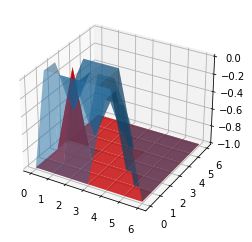

In [238]:
from mpl_toolkits.mplot3d import Axes3D

# Set up grid and test data
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(N), range(N))  # `plot_surface` expects `x` and `y` data to be 2D
EstR=ha.plot_surface(X, Y, R_est[:,:,1],alpha=0.5)
TruR=ha.plot_surface(X, Y, true_R,alpha=0.8,color='r')
plt.show()

In [132]:
plt.draw()
plt.show()

<Figure size 432x288 with 0 Axes>

In [123]:

plt.show()

<Figure size 432x288 with 0 Axes>

Making animation


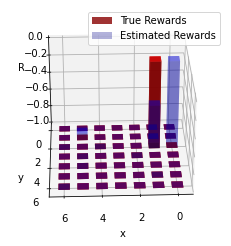

In [239]:
import matplotlib.animation as animation

# Set up grid and test data
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

# We want to illustrate the locations where correct action is taken.
# fake data
_x = np.arange(N)
_y = np.arange(N)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel()-0.3, _yy.ravel()-0.3

# top = 0.01*(pi==opt_pi).ravel()
bottom = -1*np.ones_like(top)
width = depth = 0.6

X, Y = np.meshgrid(range(N), range(N))  # `plot_surface` expects `x` and `y` data to be 2D
TruR=ha.bar3d(x, y, bottom, width, depth, true_R.ravel()+1,alpha=0.8,color='r',label='True Rewards')
EstR=ha.bar3d(x, y, bottom, width, depth, R_est[:,:,0].ravel()+1,alpha=0.3,color='b',label='Estimated Rewards')

# These set of lines are one of them magical fixes to work around buggy legend plotting. 
TruR._facecolors2d=TruR.get_facecolor
TruR._edgecolors2d=TruR.get_edgecolor
EstR._facecolors2d=EstR.get_facecolor
EstR._edgecolors2d=EstR.get_edgecolor

ha.legend()
ha.set_xlabel('x')
ha.set_ylabel('y')
ha.set_zlabel('R')
def reward_evolve(m):
    global EstR
    if m>=40:
        EstR.remove()
        EstR=ha.bar3d(x, y, bottom, width, depth, R_est[:,:,-1].ravel()+1,alpha=0.3,color='b',label='Estimated Rewards')
    else:
        EstR.remove()
        ha.view_init(azim=10+m*2)
        EstR=ha.bar3d(x, y, bottom, width, depth, R_est[:,:,m].ravel()+1,alpha=0.3,color='b',label='Estimated Rewards')

print("Making animation")
# The +10 intriduces a pause time of 10*200 milliseconds.
rot_animation = animation.FuncAnimation(hf, reward_evolve, frames=np.arange(0, 40+10, 1), interval=200, repeat=True, repeat_delay=1500)
rot_animation.save('rotation.gif', dpi=80, writer='imagemagick')

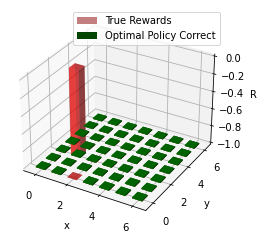

In [257]:
# Set up grid and test data
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

# We want to illustrate the locations where correct action is taken.
# fake data
_x = np.arange(N)
_y = np.arange(N)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel()-0.3, _yy.ravel()-0.3

top = 0.01*(pi==opt_pi).ravel()
bottom = -1*np.ones_like(top)
width = depth = 0.6

# We want to remove indices where top attrains 0.
index=[]
for i,t in enumerate(top):
    if t==0:
        index.append(i)

top_pi=np.delete(top, index)
x_pi=np.delete(x, index)
y_pi=np.delete(y, index)
bottom_pi=np.delete(bottom, index)


X, Y = np.meshgrid(range(N), range(N))  # `plot_surface` expects `x` and `y` data to be 2D
# EstR=ha.plot_surface(X, Y, R_est[:,:,1],alpha=0.5)
TruR=ha.bar3d(x, y, bottom, width, depth, true_R.ravel()+1,alpha=0.5,color='r',label='True Rewards')
dev_pi=ha.bar3d(x_pi, y_pi, bottom_pi, width, depth, top_pi, color='g',shade=True,label='Optimal Policy Correct')

TruR._facecolors2d=TruR.get_facecolor
TruR._edgecolors2d=TruR.get_edgecolor
dev_pi._facecolors2d=dev_pi.get_facecolor
dev_pi._edgecolors2d=dev_pi.get_edgecolor

ha.legend()
ha.set_xlabel('x')
ha.set_ylabel('y')
ha.set_zlabel('R')
plt.show()

Text(0.5, 0, 'R')

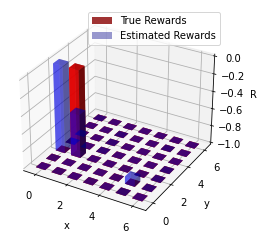

In [255]:
# Set up grid and test data
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

# We want to illustrate the locations where correct action is taken.
# fake data
_x = np.arange(N)
_y = np.arange(N)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel()-0.3, _yy.ravel()-0.3

# top = 0.01*(pi==opt_pi).ravel()
bottom = -1*np.ones_like(top)
width = depth = 0.6

X, Y = np.meshgrid(range(N), range(N))  # `plot_surface` expects `x` and `y` data to be 2D
TruR=ha.bar3d(x, y, bottom, width, depth, true_R.ravel()+1,alpha=0.8,color='r',label='True Rewards')
EstR=ha.bar3d(x, y, bottom, width, depth, R_est[:,:,39].ravel()+1,alpha=0.4,color='b',label='Estimated Rewards')

# These set of lines are one of them magical fixes to work around buggy legend plotting. 
TruR._facecolors2d=TruR.get_facecolor
TruR._edgecolors2d=TruR.get_edgecolor
EstR._facecolors2d=EstR.get_facecolor
EstR._edgecolors2d=EstR.get_edgecolor

ha.legend()
ha.set_xlabel('x')
ha.set_ylabel('y')
ha.set_zlabel('R')

In [177]:
(pi==opt_pi).ravel()

array([ True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False, False,  True,  True])

In [77]:
red

array([2, 1])

In [49]:
true_R

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1.,  0., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]])

In [90]:
true_v_of_pol

[-5.309890229878452]